# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

We set the random seed so that the results don't vary drastically.

In [1]:
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib as matplotlib

# Set seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

# Import Keras from TensorFlow
from tensorflow import keras
from tensorflow.keras import backend as K

2025-03-31 01:00:39.420720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743363039.515096    5667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743363039.542805    5667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743363039.668973    5667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743363039.668995    5667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743363039.668997    5667 computation_placer.cc:177] computation placer alr

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [2]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 4 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [3]:
import os
import numpy as np
import cv2

def generator(source_path, folder_list, batch_size, num_frames):
    # Constants for video and image processing
    # num_frames = 15   # number of frames per video
    img_height = 112  # target height for each frame
    img_width = 112   # target width for each frame
    num_classes = 5   # number of output classes
    
    # Create a list of frame indices to pick from each video folder
    img_idx = list(range(num_frames))
    
    while True:
        # Shuffle the folder list
        t = np.random.permutation(folder_list)
        # Calculate the number of full batches
        num_batches = len(t) // batch_size
        
        # Process full batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
            
            for i in range(batch_size):
                # Each folder entry is assumed to be formatted as "folder_name;other_info;label_index"
                folder_info = t[i + batch * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                # List and sort images in the folder to ensure consistent ordering
                imgs = os.listdir(os.path.join(source_path, folder_name))
                imgs.sort()
                
                # Process each selected frame
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(source_path, folder_name, imgs[item])
                    # Read image using cv2
                    image = cv2.imread(image_path)
                    # Convert from BGR (default in cv2) to RGB
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    # Resize image to target dimensions (width, height order for cv2)
                    image = cv2.resize(image, (img_width, img_height))
                    # Normalize image
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                # Create one-hot label
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels
        
        # Process any remaining folders that don't form a full batch
        remainder = len(t) % batch_size
        if remainder > 0:
            batch_data = np.zeros((remainder, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((remainder, num_classes), dtype=np.float32)
            
            for i in range(remainder):
                folder_info = t[i + num_batches * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                imgs = os.listdir(os.path.join(source_path, folder_name))
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(source_path, folder_name, imgs[item])
                    image = cv2.imread(image_path)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [4]:
import datetime

# Get the current date and time
curr_dt_time = datetime.datetime.now()
print("Current date and time:", curr_dt_time)

# Define paths for training and validation datasets
train_path = './Project_data/train'
val_path = './Project_data/val'

# Assuming train_doc and val_doc are lists containing the training and validation data
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# Choose the number of epochs, here we set it to 10 (modify as needed)
num_epochs = 10
print('# epochs =', num_epochs)


Current date and time: 2025-03-31 01:00:41.835585
# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [5]:
# Import Keras from TensorFlow
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, TimeDistributed, BatchNormalization, Activation, LSTM
from tensorflow.keras.layers import Conv3D, MaxPooling3D, MaxPooling2D, Input, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#### Experiment 1

(CNN + Batch Normalisation) 

In [6]:
# Define input dimensions for your video data
num_frames = 15   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


I0000 00:00:1743363042.594848    5667 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1743363042.596431    5667 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5712 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 15, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 15, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 15, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 15, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 8, 28, 28, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 28, 28, 64)  │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 8, 28, 28, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 4, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,971,845 (99.07 MB)

 Trainable params: 25,971,397 (99.07 MB)

 Non-trainable params: 448 (1.75 KB)

None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [9]:
# Define model name and create directory if it doesn't exist
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the filepath for saving the model
filepath = model_name + "model-{epoch:02d}-{loss:.2f}-{categorical_accuracy:.2f}.h5"

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Define the ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

# List of callbacks
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/10


I0000 00:00:1743363044.667211    5846 service.cc:152] XLA service 0x71a798010670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743363044.667251    5846 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-03-31 01:00:44.726253: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743363044.962085    5846 cuda_dnn.cc:529] Loaded cuDNN version 90800


  4/166 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - categorical_accuracy: 0.0000e+00 - loss: 4.9549

I0000 00:00:1743363049.270766    5846 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - categorical_accuracy: 0.3512 - loss: 4.4284
Epoch 1: saving model to model_init_2025-03-3101_00_41.835585/model-01-3.29-0.40.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 24s 108ms/step - categorical_accuracy: 0.3515 - loss: 4.4216 - val_categorical_accuracy: 0.2100 - val_loss: 7.4736 - learning_rate: 1.0000e-04
Epoch 2/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - categorical_accuracy: 0.6928 - loss: 1.0420
Epoch 2: saving model to model_init_2025-03-3101_00_41.835585/model-02-0.84-0.71.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - categorical_accuracy: 0.6931 - loss: 1.0395 - val_categorical_accuracy: 0.2100 - val_loss: 4.6142 - learning_rate: 1.0000e-04
Epoch 3/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - categorical_accuracy: 0.7774 - loss: 0.6640
Epoch 3: saving model to model_init_2025-03-3101_00_41.835585/model-03-0.66-0.77.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - categorical_accuracy: 0.7773 - loss: 0.6639 - val_categorical_accuracy: 0.5500 - val_loss: 1.5988 - learning_rate: 1.0000e-04
Epoch 4/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - categorical_accuracy: 0.8945 - loss: 0.3910
Epoch 4: saving model to model_init_2025-03-3101_00_41.835585/model-04-0.41-0.88.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - categorical_accuracy: 0.8944 - loss: 0.3911 - val_categorical_accuracy: 0.6400 - val_loss: 1.3354 - learning_rate: 1.0000e-04
Epoch 5/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - categorical_accuracy: 0.8872 - loss: 0.3545
Epoch 5: saving model to model_init_2025-03-3101_00_41.835585/model-05-0.43-0.87.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - categorical_accuracy: 0.8870 - loss: 0.3554 - val_categorical_accuracy: 0.7100 - val_loss: 1.1124 - learning_rate: 1.0000e-04
Epoch 6/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - categorical_accuracy: 0.8529 - loss: 0.4362
Epoch 6: saving model to model_init_2025-03-3101_00_41.835585/model-06-0.43-0.86.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - categorical_accuracy: 0.8531 - loss: 0.4362 - val_categorical_accuracy: 0.7200 - val_loss: 1.5971 - learning_rate: 1.0000e-04
Epoch 7/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9103 - loss: 0.4074
Epoch 7: saving model to model_init_2025-03-3101_00_41.835585/model-07-0.53-0.88.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - categorical_accuracy: 0.9099 - loss: 0.4089 - val_categorical_accuracy: 0.6600 - val_loss: 2.3753 - learning_rate: 1.0000e-04
Epoch 8/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8960 - loss: 0.4241
Epoch 8: saving model to model_init_2025-03-3101_00_41.835585/model-08-0.35-0.90.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - categorical_accuracy: 0.8961 - loss: 0.4232 - val_categorical_accuracy: 0.6700 - val_loss: 1.7282 - learning_rate: 1.0000e-04
Epoch 9/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.9054 - loss: 0.3686
Epoch 9: saving model to model_init_2025-03-3101_00_41.835585/model-09-0.45-0.89.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - categorical_accuracy: 0.9053 - loss: 0.3691 - val_categorical_accuracy: 0.4800 - val_loss: 4.3632 - learning_rate: 1.0000e-04
Epoch 10/10
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - categorical_accuracy: 0.8889 - loss: 0.3818
Epoch 10: saving model to model_init_2025-03-3101_00_41.835585/model-10-0.34-0.90.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - categorical_accuracy: 0.8891 - loss: 0.3813 - val_categorical_accuracy: 0.7800 - val_loss: 1.3273 - learning_rate: 1.0000e-04


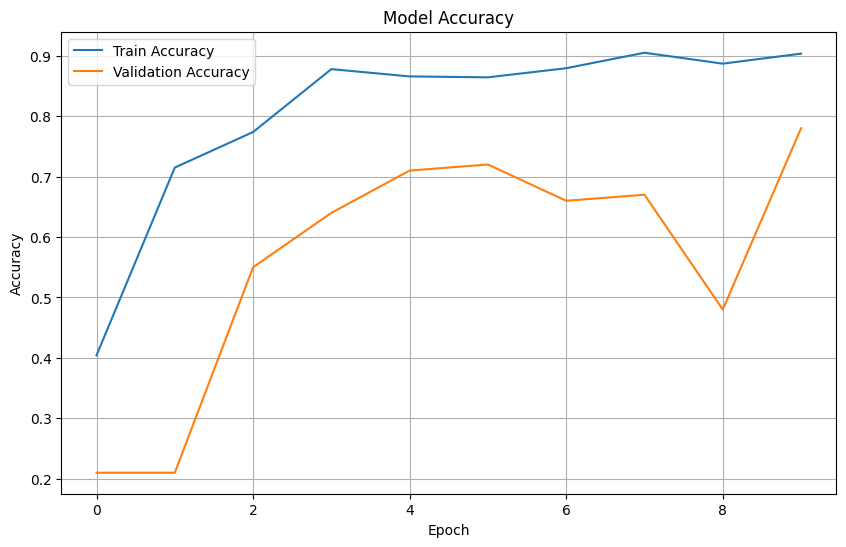

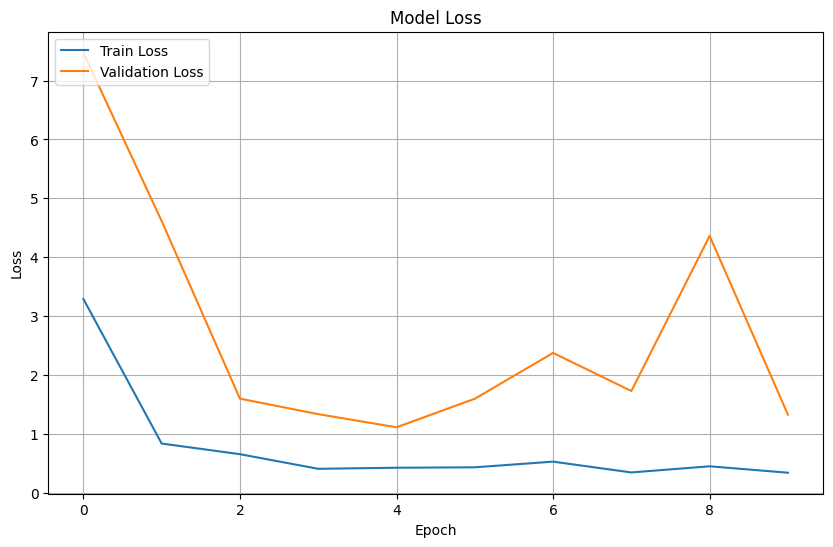

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Experiment 2

(CNN + Batch Normalisation) - increased number of frames and epochs

In [13]:
# Define input dimensions for your video data
num_frames = 25   # Number of frames per video
img_height = 112  # Height of each frame
img_width = 112   # Width of each frame

# Define the input shape (3 channels for RGB)
input_shape = (num_frames, img_height, img_width, 3)

model = Sequential()
# Use an explicit Input layer
model.add(Input(shape=input_shape))

# 1st convolutional block
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same'))
model.add(BatchNormalization())

# 2nd convolutional block
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# 3rd convolutional block
model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Final classification layer - assumes 5 classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

In [14]:


# Define your optimizer
optimizer = Adam(learning_rate=1e-4)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_3 (Conv3D)               │ (None, 25, 112, 112,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 25, 56, 56, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 56, 56, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 25, 56, 56, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_4 (MaxPooling3D)  │ (None, 13, 28, 28, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 13, 28, 28, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_5 (Conv3D)               │ (None, 13, 28, 28,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_5 (MaxPooling3D)  │ (None, 7, 14, 14, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 14, 14, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 175616)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    44,957,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,239,429 (172.57 MB)

 Trainable params: 45,238,981 (172.57 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [15]:
# Define your generators
train_generator = generator(train_path, train_doc, batch_size, num_frames=num_frames)
val_generator = generator(val_path, val_doc, batch_size, num_frames=num_frames)

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [17]:
# Fit the model
num_epochs = 20 # increased the epochs
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    initial_epoch=0
)


Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_accuracy: 0.4386 - loss: 6.0506
Epoch 1: saving model to model_init_2025-03-3101_00_41.835585/model-01-4.11-0.50.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - categorical_accuracy: 0.4390 - loss: 6.0390 - val_categorical_accuracy: 0.1600 - val_loss: 5.9488 - learning_rate: 1.0000e-04
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - categorical_accuracy: 0.7048 - loss: 1.1972
Epoch 2: saving model to model_init_2025-03-3101_00_41.835585/model-02-1.07-0.71.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - categorical_accuracy: 0.7048 - loss: 1.1964 - val_categorical_accuracy: 0.2500 - val_loss: 4.5145 - learning_rate: 1.0000e-04
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.8157 - loss: 0.8668
Epoch 3: saving model to model_init_2025-03-3101_00_41.835585/model-03-0.95-0.78.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - categorical_accuracy: 0.8155 - loss: 0.8673 - val_categorical_accuracy: 0.6200 - val_loss: 1.6410 - learning_rate: 1.0000e-04
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - categorical_accuracy: 0.8398 - loss: 0.8446
Epoch 4: saving model to model_init_2025-03-3101_00_41.835585/model-04-0.73-0.84.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - categorical_accuracy: 0.8398 - loss: 0.8438 - val_categorical_accuracy: 0.8200 - val_loss: 0.7830 - learning_rate: 1.0000e-04
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - categorical_accuracy: 0.8609 - loss: 0.4526
Epoch 5: saving model to model_init_2025-03-3101_00_41.835585/model-05-0.43-0.87.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - categorical_accuracy: 0.8610 - loss: 0.4525 - val_categorical_accuracy: 0.8200 - val_loss: 0.5365 - learning_rate: 1.0000e-04
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - categorical_accuracy: 0.9090 - loss: 0.2699
Epoch 6: saving model to model_init_2025-03-3101_00_41.835585/model-06-0.26-0.92.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 16s 95ms/step - categorical_accuracy: 0.9090 - loss: 0.2698 - val_categorical_accuracy: 0.9000 - val_loss: 0.5556 - learning_rate: 1.0000e-04
Epoch 7/20
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_accuracy: 0.9240 - loss: 0.2317
Epoch 7: saving model to model_init_2025-03-3101_00_41.835585/model-07-0.23-0.93.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - categorical_accuracy: 0.9240 - loss: 0.2318 - val_categorical_accuracy: 0.8200 - val_loss: 0.9313 - learning_rate: 1.0000e-04
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.9094 - loss: 0.3913
Epoch 8: saving model to model_init_2025-03-3101_00_41.835585/model-08-0.44-0.91.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - categorical_accuracy: 0.9094 - loss: 0.3916 - val_categorical_accuracy: 0.7900 - val_loss: 0.9088 - learning_rate: 1.0000e-04
Epoch 9/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.9162 - loss: 0.3191
Epoch 9: saving model to model_init_2025-03-3101_00_41.835585/model-09-0.32-0.92.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - categorical_accuracy: 0.9162 - loss: 0.3191 - val_categorical_accuracy: 0.8100 - val_loss: 1.0545 - learning_rate: 1.0000e-04
Epoch 10/20
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.9013 - loss: 0.4624
Epoch 10: saving model to model_init_2025-03-3101_00_41.835585/model-10-0.39-0.91.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - categorical_accuracy: 0.9014 - loss: 0.4615 - val_categorical_accuracy: 0.8100 - val_loss: 1.3045 - learning_rate: 1.0000e-04
Epoch 11/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.9065 - loss: 0.4488
Epoch 11: saving model to model_init_2025-03-3101_00_41.835585/model-11-0.35-0.92.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - categorical_accuracy: 0.9066 - loss: 0.4482 - val_categorical_accuracy: 0.7800 - val_loss: 1.1155 - learning_rate: 1.0000e-04
Epoch 12/20
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.9152 - loss: 0.3207
Epoch 12: saving model to model_init_2025-03-3101_00_41.835585/model-12-0.45-0.90.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - categorical_accuracy: 0.9151 - loss: 0.3223 - val_categorical_accuracy: 0.7700 - val_loss: 1.8711 - learning_rate: 1.0000e-04
Epoch 13/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_accuracy: 0.8946 - loss: 0.7432
Epoch 13: saving model to model_init_2025-03-3101_00_41.835585/model-13-0.61-0.89.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - categorical_accuracy: 0.8946 - loss: 0.7425 - val_categorical_accuracy: 0.8000 - val_loss: 1.5569 - learning_rate: 1.0000e-04
Epoch 14/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.9182 - loss: 0.4188
Epoch 14: saving model to model_init_2025-03-3101_00_41.835585/model-14-0.45-0.92.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - categorical_accuracy: 0.9182 - loss: 0.4190 - val_categorical_accuracy: 0.7700 - val_loss: 1.7557 - learning_rate: 1.0000e-04
Epoch 15/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.9488 - loss: 0.3249
Epoch 15: saving model to model_init_2025-03-3101_00_41.835585/model-15-0.33-0.94.h5



Epoch 15: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - categorical_accuracy: 0.9487 - loss: 0.3249 - val_categorical_accuracy: 0.8700 - val_loss: 0.6451 - learning_rate: 1.0000e-04
Epoch 16/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_accuracy: 0.9408 - loss: 0.2040
Epoch 16: saving model to model_init_2025-03-3101_00_41.835585/model-16-0.20-0.94.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - categorical_accuracy: 0.9408 - loss: 0.2040 - val_categorical_accuracy: 0.8600 - val_loss: 0.4655 - learning_rate: 1.0000e-05
Epoch 17/20
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.9568 - loss: 0.1893
Epoch 17: saving model to model_init_2025-03-3101_00_41.835585/model-17-0.18-0.95.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - categorical_accuracy: 0.9568 - loss: 0.1891 - val_categorical_accuracy: 0.8500 - val_loss: 0.5536 - learning_rate: 1.0000e-05
Epoch 18/20
165/166 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - categorical_accuracy: 0.9689 - loss: 0.0993
Epoch 18: saving model to model_init_2025-03-3101_00_41.835585/model-18-0.07-0.98.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - categorical_accuracy: 0.9690 - loss: 0.0990 - val_categorical_accuracy: 0.8400 - val_loss: 0.5236 - learning_rate: 1.0000e-05
Epoch 19/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - categorical_accuracy: 0.9662 - loss: 0.1116
Epoch 19: saving model to model_init_2025-03-3101_00_41.835585/model-19-0.10-0.97.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - categorical_accuracy: 0.9662 - loss: 0.1115 - val_categorical_accuracy: 0.8600 - val_loss: 0.5085 - learning_rate: 1.0000e-05
Epoch 20/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - categorical_accuracy: 0.9786 - loss: 0.1345
Epoch 20: saving model to model_init_2025-03-3101_00_41.835585/model-20-0.08-0.98.h5


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - categorical_accuracy: 0.9786 - loss: 0.1342 - val_categorical_accuracy: 0.8700 - val_loss: 0.5132 - learning_rate: 1.0000e-05


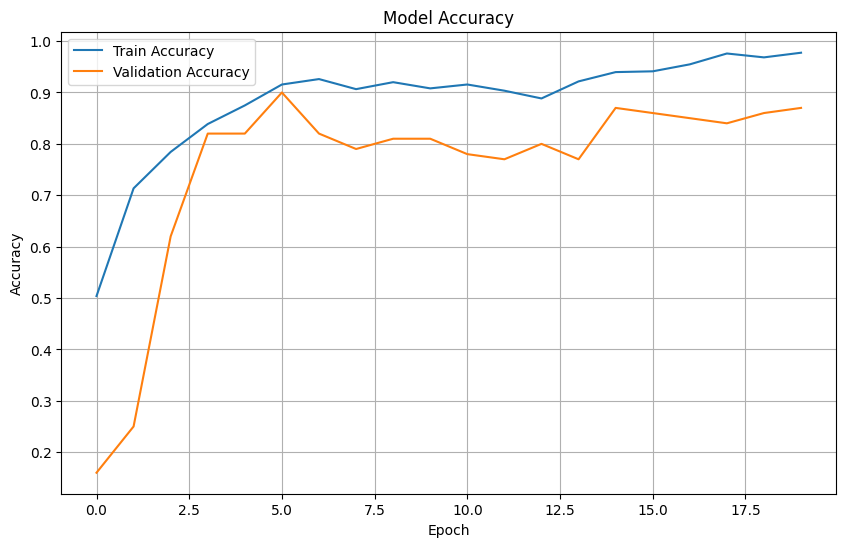

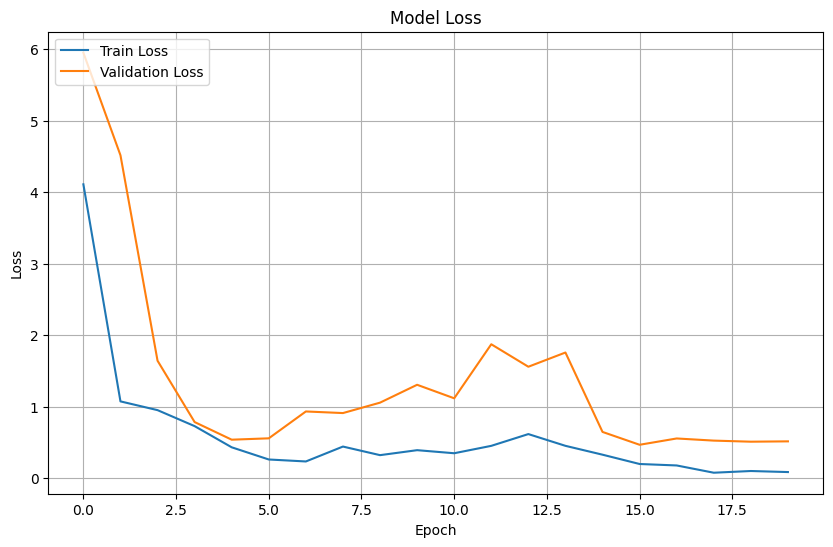

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

### Experiment 3

#### (CNN + LSTM)

In [19]:
def generator(source_path, folder_list, batch_size, num_frames):
    """
    Yields batches of video data and one-hot labels.
    
    Each folder entry is assumed to be formatted as "folder_name;other_info;label_index".
    """
    # Constants for video processing
    img_height = 112   # target height
    img_width = 112    # target width
    num_classes = 5    # number of classes
    
    # List of frame indices to use for each video folder
    img_idx = list(range(num_frames))
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size

        # Process full batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, num_classes), dtype=np.float32)
            
            for i in range(batch_size):
                # "folder_name;other_info;label_index"
                folder_info = t[i + batch * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue  # Skip if the image is not read properly
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels
        
        # Process remaining samples (if any)
        remainder = len(t) % batch_size
        if remainder > 0:
            batch_data = np.zeros((remainder, num_frames, img_height, img_width, 3), dtype=np.float32)
            batch_labels = np.zeros((remainder, num_classes), dtype=np.float32)
            
            for i in range(remainder):
                folder_info = t[i + num_batches * batch_size].strip().split(';')
                folder_name = folder_info[0]
                label = int(folder_info[2])
                
                folder_path = os.path.join(source_path, folder_name)
                imgs = os.listdir(folder_path)
                imgs.sort()
                
                for idx, item in enumerate(img_idx):
                    image_path = os.path.join(folder_path, imgs[item])
                    image = cv2.imread(image_path)
                    if image is None:
                        continue
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (img_width, img_height))
                    norm_image = image.astype(np.float32) / 255.0
                    batch_data[i, idx, :, :, :] = norm_image
                
                batch_labels[i, label] = 1
            
            yield batch_data, batch_labels

In [20]:
# -------------------------
# Model Definition (CNN + LSTM)
# -------------------------
num_frames = 16
img_height = 112
img_width = 112
num_classes = 5

# Input: a sequence of frames
inputs = Input(shape=(num_frames, img_height, img_width, 3))
# TimeDistributed CNN: apply Conv2D on each frame
x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(Flatten())(x)
# LSTM to capture temporal dynamics
x = LSTM(128, return_sequences=False)(x)
# Dense layers for classification
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 16, 28, 28, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,810,245 (98.46 MB)

 Trainable params: 25,810,053 (98.46 MB)

 Non-trainable params: 192 (768.00 B)

In [21]:
num_train_sequences = len(train_doc)
num_val_sequences = len(val_doc)

# -------------------------
# Training Setup
# -------------------------
batch_size = 2  # Reduce batch size to help mitigate memory issues

# Create tf.data.Dataset from the generator
def get_dataset(source_path, doc, batch_size, num_frames):
    return tf.data.Dataset.from_generator(
        lambda: generator(source_path, doc, batch_size, num_frames),
        output_signature=(
            tf.TensorSpec(shape=(None, num_frames, img_height, img_width, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, num_classes), dtype=tf.float32)
        )
    )

train_dataset = get_dataset(train_path, train_doc, batch_size, num_frames)
val_dataset = get_dataset(val_path, val_doc, batch_size, num_frames)

# Repeat and prefetch datasets
train_dataset = train_dataset.repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.repeat().prefetch(tf.data.AUTOTUNE)

In [22]:
steps_per_epoch = (num_train_sequences // batch_size) + (1 if num_train_sequences % batch_size else 0)
validation_steps = (num_val_sequences // batch_size) + (1 if num_val_sequences % batch_size else 0)

# Callback: Early stopping based on validation loss
callbacks_list = [EarlyStopping(monitor='val_loss', patience=3, verbose=1)]

In [23]:
num_epochs = 10
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    initial_epoch=0
)

Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - categorical_accuracy: 0.2740 - loss: 1.6241 - val_categorical_accuracy: 0.4900 - val_loss: 1.3547
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.4774 - loss: 1.3249 - val_categorical_accuracy: 0.4900 - val_loss: 1.2157
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - categorical_accuracy: 0.5653 - loss: 1.1611 - val_categorical_accuracy: 0.5100 - val_loss: 1.1535
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - categorical_accuracy: 0.6481 - loss: 0.9401 - val_categorical_accuracy: 0.6100 - val_loss: 1.0411
Epoch 5/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy: 0.7532 - loss: 0.7449 - val_categorical_accuracy: 0.6500 - val_loss: 0.9078
Epoch 6/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - categorical_accuracy: 0.8761 - loss: 0.4915 - val_categorical_accuracy: 0.6500 - val_loss: 0.8876
Epoch 7/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - categorical_accuracy

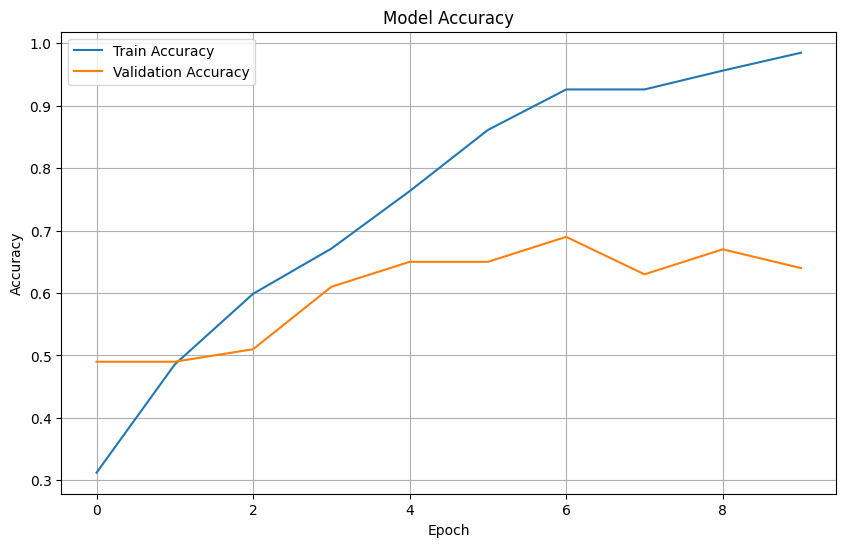

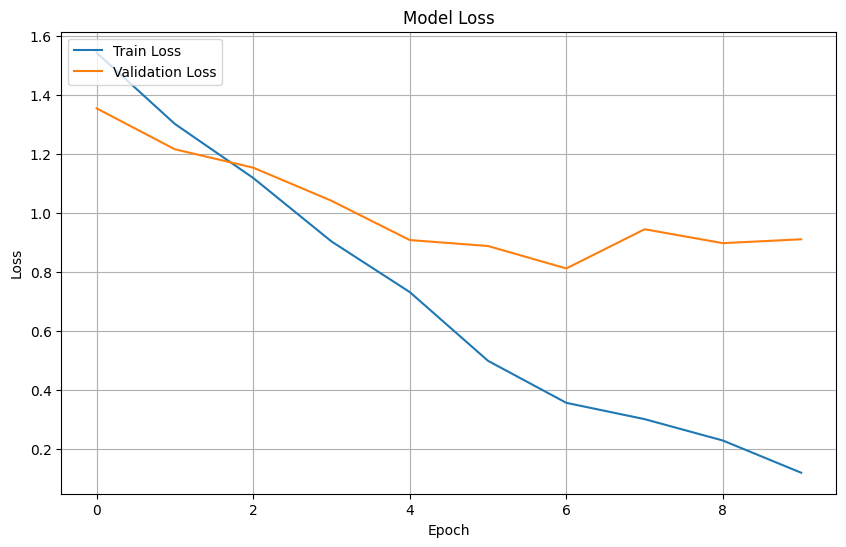

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

## Summary

Experiment 2 (Gesture Recognition): Integrated a CNN with Batch Normalization, increased the number of frames per video sample, and extended training epochs.
These enhancements improved feature extraction and generalization, leading to higher training and validation accuracy in gesture recognition.